In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
%matplotlib inline
import matplotlib as plt
import matplotlib.style as stl
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from os import cpu_count

In [97]:
plt.rcParams['figure.figsize'] = 16, 10

In [87]:
import pylab

In [2]:
pd.options.display.max_columns = None
n_jobs = max(cpu_count()-1, 1)

In [270]:
train_df = pd.read_csv('train.csv',sep='\t').drop('Unnamed: 0',axis=1)
test_df = pd.read_csv('test.csv',sep='\t').drop('Unnamed: 0',axis=1)

# Preprocessing

In [271]:
#9 is highly correlated with 2
correlated = ['9']
constant_values = ['5', '11', '129', '130', '137', '138', '141', '149', '150', '178', '186', '188', '192', '193', '291', '301', '303', '305','152', '160','140', '164']

#too_much_zeros_features = ['191', '182', '185', '181', '172', '170', '157', '136', '135']

In [272]:
train_df = train_df.drop(correlated,axis=1)
train_df = train_df.drop(constant_values,axis=1)
test_df = test_df.drop(correlated,axis=1)
test_df = test_df.drop(constant_values,axis=1)

In [273]:
test_df.shape

(4166, 323)

In [275]:
test_df.head()

,0,1,2,3,4,6,7,8,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,131,132,133,134,135,136,139,142,143,144,145,146,147,148,151,153,154,155,156,157,158,159,161,162,163,165,166,167,168,169,170,171,172,173,174,175,176,177,179,180,181,182,183,184,185,187,189,190,191,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,292,293,294,295,296,297,298,299,300,302,304,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345
0,NaN,1,0,0,1,0,0.136364,0,1,1,0.555556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0.0,0.00000,0.0,0.0,0.35921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.89803,0.0,0.17961,0.17961,0.153846,0.028939,0.457598,1,1,1,1.000000,1.000000,0.389702,0.207745,0.046700,0.293568,0.133332,0.108743,0.30,0.304348,0.555556,0.052021,0.5,0.445127,0.844436,0.258310,0.120536,0.851549,0.308740,0.5,0.969052,0.997754,0.075269,0.044124,0.828099,0.014678,0.5,0.326132,0.916168,0.075269,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.044124,0.828099,0.207479,0.152690,0.175073,0.549325,0.478620,0.509881,0.292150,0.702982,0.237822,0.645717,0.338190,0.249612,0.754017,0.304419,0.888042,1.0,1.0,0.761512,0.153585,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.388995,0.842112,0.461724,0.446615,0.078764,0,0.071850,1,0.279886,0.429293,0.051663,0.638350,0.499279,0.116236,0.001895,0.268333,0.623211,0.480870,0.519130,0.199035,0.890508,1,0.077291,0.574936,0.134728,0.192984,0,1,0,0,0.222222,1,1,1,1
1,NaN,1,0,0,1,0,0.181818,0,1,1,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1.0,0.00000,0.0,0.00000,0.00000,0.038462,0.014469,0.357848,0,1,1,0.135797,1.000000,1.000000,0.390839,0.160103,0.753314,0.097754,0.198160,0.35,0.130435,0.555556,0.011364,0.5,0.237096,0.812458,0.531814,0.151517,0.872622,0.017888,0.5,0.374784,0.926647,0.096774,0.038142,0.820386,0.308740,0.5,0.969052,0.997754,0.021505,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.018921,0.781267,0.107577,0.186750,0.179621,0.420534,0.431057,0.942957,0.057501,0.672653,0.267041,0.515884,0.161280,0.092513,0.697888,0.206254,0.867580,1.0,1.0,0.768640,0.040349,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.075937,0.572285,0.239612,1.000000,1.000000,0,0.096645,1,0.087719,0.376263,0.011455,0.456479,0.113528,0.099443,0.007252,0.418232,0.596438,0.254130,0.741635,0.091947,0.838127,0,0.082511,0.585569,0.042731,0.195690,0,1,0,0,0.000000,1,1,1,0
2,NaN,1,0,0,0,0,0.090909,0,1,1,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0.0,0.57735,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57735,0.0,0.0,0.57735,0.0,0.00000,0.00000,0.115385,0.004823,0.215445

# Base model

In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
X = train_df.drop(['0'], axis=1)
y = train_df['0']

In [232]:
parameters={
   'objective': 'binary',
    'learning_rate': 0.01,
    'max_depth': 8,
    'num_threads': 4,
    'metric': 'auc',
    'seed': 42,
    'colsample_bytree': 0.65,
    'subsample': 0.8,
    'subsample_freq': 2,
    'min_data_in_leaf': 15,
}
n_rounds = 10000

In [9]:
lgb_train = lgb.Dataset(X, label=y, free_raw_data=False)

In [10]:
result_base = lgb.cv(parameters, lgb_train, n_rounds, folds=skf.split(X, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.678943 + 0.00414656
[2]	cv_agg's auc: 0.691799 + 0.00885539
[3]	cv_agg's auc: 0.699423 + 0.00930007
[4]	cv_agg's auc: 0.705288 + 0.00752174
[5]	cv_agg's auc: 0.706464 + 0.00864524
[6]	cv_agg's auc: 0.70811 + 0.00701798
[7]	cv_agg's auc: 0.708472 + 0.00756751
[8]	cv_agg's auc: 0.709882 + 0.00786181
[9]	cv_agg's auc: 0.710649 + 0.00688371
[10]	cv_agg's auc: 0.710904 + 0.00661881
[11]	cv_agg's auc: 0.710834 + 0.00638842
[12]	cv_agg's auc: 0.710676 + 0.00615256
[13]	cv_agg's auc: 0.710921 + 0.00597416
[14]	cv_agg's auc: 0.710913 + 0.00600064
[15]	cv_agg's auc: 0.71076 + 0.00636688
[16]	cv_agg's auc: 0.710813 + 0.00675971
[17]	cv_agg's auc: 0.710831 + 0.00641083
[18]	cv_agg's auc: 0.711278 + 0.00649868
[19]	cv_agg's auc: 0.711492 + 0.00622084
[20]	cv_agg's auc: 0.711621 + 0.00583808
[21]	cv_agg's auc: 0.711569 + 0.00573416
[22]	cv_agg's auc: 0.712189 + 0.0056832
[23]	cv_agg's auc: 0.712196 + 0.00565143
[24]	cv_agg's auc: 0.71195 + 0.00554054
[25]	cv_agg's auc: 0.712087 +

[200]	cv_agg's auc: 0.729914 + 0.00528729
[201]	cv_agg's auc: 0.729959 + 0.0052274
[202]	cv_agg's auc: 0.729994 + 0.0052377
[203]	cv_agg's auc: 0.730061 + 0.0051952
[204]	cv_agg's auc: 0.730121 + 0.00517114
[205]	cv_agg's auc: 0.730207 + 0.00513997
[206]	cv_agg's auc: 0.73029 + 0.005194
[207]	cv_agg's auc: 0.730317 + 0.00516323
[208]	cv_agg's auc: 0.730384 + 0.0050836
[209]	cv_agg's auc: 0.730397 + 0.00512006
[210]	cv_agg's auc: 0.730447 + 0.00511987
[211]	cv_agg's auc: 0.730537 + 0.0051367
[212]	cv_agg's auc: 0.730671 + 0.00513893
[213]	cv_agg's auc: 0.730777 + 0.00511802
[214]	cv_agg's auc: 0.730925 + 0.0050895
[215]	cv_agg's auc: 0.73104 + 0.00511107
[216]	cv_agg's auc: 0.731168 + 0.00514245
[217]	cv_agg's auc: 0.731291 + 0.0051576
[218]	cv_agg's auc: 0.731437 + 0.00514138
[219]	cv_agg's auc: 0.731521 + 0.00514935
[220]	cv_agg's auc: 0.731596 + 0.00511187
[221]	cv_agg's auc: 0.73168 + 0.00516059
[222]	cv_agg's auc: 0.731796 + 0.00520714
[223]	cv_agg's auc: 0.731865 + 0.00526018
[224

[400]	cv_agg's auc: 0.74019 + 0.00601696
[401]	cv_agg's auc: 0.740196 + 0.00599507
[402]	cv_agg's auc: 0.74021 + 0.00598366
[403]	cv_agg's auc: 0.740222 + 0.00599678
[404]	cv_agg's auc: 0.740221 + 0.00606588
[405]	cv_agg's auc: 0.740264 + 0.00606578
[406]	cv_agg's auc: 0.740302 + 0.00607427
[407]	cv_agg's auc: 0.740327 + 0.00608929
[408]	cv_agg's auc: 0.740331 + 0.00607602
[409]	cv_agg's auc: 0.740353 + 0.00604269
[410]	cv_agg's auc: 0.740372 + 0.00604482
[411]	cv_agg's auc: 0.740377 + 0.00603633
[412]	cv_agg's auc: 0.740416 + 0.00602365
[413]	cv_agg's auc: 0.740422 + 0.00603471
[414]	cv_agg's auc: 0.74047 + 0.00601619
[415]	cv_agg's auc: 0.740499 + 0.0059924
[416]	cv_agg's auc: 0.740531 + 0.0060083
[417]	cv_agg's auc: 0.740559 + 0.00599365
[418]	cv_agg's auc: 0.740604 + 0.00599028
[419]	cv_agg's auc: 0.740613 + 0.00599272
[420]	cv_agg's auc: 0.74059 + 0.00596812
[421]	cv_agg's auc: 0.740624 + 0.00593429
[422]	cv_agg's auc: 0.740642 + 0.00592547
[423]	cv_agg's auc: 0.740667 + 0.0059069

[597]	cv_agg's auc: 0.744352 + 0.00577757
[598]	cv_agg's auc: 0.744378 + 0.00578039
[599]	cv_agg's auc: 0.744367 + 0.00575947
[600]	cv_agg's auc: 0.744412 + 0.00571082
[601]	cv_agg's auc: 0.744455 + 0.0057506
[602]	cv_agg's auc: 0.744474 + 0.0057172
[603]	cv_agg's auc: 0.74449 + 0.00573312
[604]	cv_agg's auc: 0.744509 + 0.00575296
[605]	cv_agg's auc: 0.744506 + 0.00578911
[606]	cv_agg's auc: 0.744552 + 0.00577781
[607]	cv_agg's auc: 0.744562 + 0.00578086
[608]	cv_agg's auc: 0.744564 + 0.00579106
[609]	cv_agg's auc: 0.744554 + 0.00580131
[610]	cv_agg's auc: 0.744577 + 0.00579368
[611]	cv_agg's auc: 0.744604 + 0.00583317
[612]	cv_agg's auc: 0.744631 + 0.00583064
[613]	cv_agg's auc: 0.744634 + 0.00582463
[614]	cv_agg's auc: 0.744635 + 0.00580601
[615]	cv_agg's auc: 0.744635 + 0.00580066
[616]	cv_agg's auc: 0.744668 + 0.00581085
[617]	cv_agg's auc: 0.744653 + 0.00578686
[618]	cv_agg's auc: 0.744637 + 0.00578878
[619]	cv_agg's auc: 0.744643 + 0.00579214
[620]	cv_agg's auc: 0.744687 + 0.0058

In [11]:
max(result_base['auc-mean']), len(result_base['auc-mean']) 

(0.7454628573901237, 716)

# Dimensionality Reduction

### PCA

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=250)

In [14]:
#pca.fit(X)

In [15]:
X_transform_pca = pca.fit_transform(X)

In [16]:
X.shape

(30500, 322)

In [17]:
X_transform_pca.shape

(30500, 250)

In [18]:
lgb_train_pca = lgb.Dataset(X_transform_pca, label=y, free_raw_data=False)

In [19]:
result_pca = lgb.cv(parameters, lgb_train_pca, n_rounds, folds=skf.split(X_transform_pca, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.619281 + 0.012692
[2]	cv_agg's auc: 0.663023 + 0.00821402
[3]	cv_agg's auc: 0.679521 + 0.00681948
[4]	cv_agg's auc: 0.687951 + 0.00766815
[5]	cv_agg's auc: 0.689274 + 0.00757241
[6]	cv_agg's auc: 0.692374 + 0.00877216
[7]	cv_agg's auc: 0.693639 + 0.00675645
[8]	cv_agg's auc: 0.695587 + 0.00642009
[9]	cv_agg's auc: 0.697503 + 0.0079983
[10]	cv_agg's auc: 0.698697 + 0.00746936
[11]	cv_agg's auc: 0.699519 + 0.00757893
[12]	cv_agg's auc: 0.70021 + 0.00740058
[13]	cv_agg's auc: 0.701043 + 0.0069817
[14]	cv_agg's auc: 0.70153 + 0.00727956
[15]	cv_agg's auc: 0.701785 + 0.00713832
[16]	cv_agg's auc: 0.701751 + 0.00705419
[17]	cv_agg's auc: 0.702382 + 0.00694194
[18]	cv_agg's auc: 0.702506 + 0.00673658
[19]	cv_agg's auc: 0.702929 + 0.00693884
[20]	cv_agg's auc: 0.703653 + 0.00762274
[21]	cv_agg's auc: 0.703592 + 0.00785723
[22]	cv_agg's auc: 0.703812 + 0.0077256
[23]	cv_agg's auc: 0.703868 + 0.00777244
[24]	cv_agg's auc: 0.704618 + 0.00790457
[25]	cv_agg's auc: 0.704933 + 0.

[201]	cv_agg's auc: 0.719562 + 0.00744468
[202]	cv_agg's auc: 0.719634 + 0.00749779
[203]	cv_agg's auc: 0.719691 + 0.00747664
[204]	cv_agg's auc: 0.719733 + 0.00749264
[205]	cv_agg's auc: 0.719779 + 0.00749532
[206]	cv_agg's auc: 0.719843 + 0.00743792
[207]	cv_agg's auc: 0.719894 + 0.00749146
[208]	cv_agg's auc: 0.719927 + 0.00747793
[209]	cv_agg's auc: 0.720047 + 0.00748312
[210]	cv_agg's auc: 0.720038 + 0.00747187
[211]	cv_agg's auc: 0.720138 + 0.00747617
[212]	cv_agg's auc: 0.720218 + 0.00744895
[213]	cv_agg's auc: 0.72025 + 0.00739369
[214]	cv_agg's auc: 0.720302 + 0.0073171
[215]	cv_agg's auc: 0.720389 + 0.00736458
[216]	cv_agg's auc: 0.720465 + 0.00733199
[217]	cv_agg's auc: 0.720584 + 0.00732354
[218]	cv_agg's auc: 0.720582 + 0.00733115
[219]	cv_agg's auc: 0.720824 + 0.00730979
[220]	cv_agg's auc: 0.720928 + 0.00735574
[221]	cv_agg's auc: 0.721016 + 0.00724668
[222]	cv_agg's auc: 0.721071 + 0.00725957
[223]	cv_agg's auc: 0.721095 + 0.00715798
[224]	cv_agg's auc: 0.721138 + 0.007

[397]	cv_agg's auc: 0.728853 + 0.00695111
[398]	cv_agg's auc: 0.728897 + 0.00694954
[399]	cv_agg's auc: 0.728956 + 0.00694382
[400]	cv_agg's auc: 0.728973 + 0.00696918
[401]	cv_agg's auc: 0.72897 + 0.00695077
[402]	cv_agg's auc: 0.72899 + 0.00690574
[403]	cv_agg's auc: 0.729057 + 0.00688665
[404]	cv_agg's auc: 0.7291 + 0.00691015
[405]	cv_agg's auc: 0.729187 + 0.0069059
[406]	cv_agg's auc: 0.729213 + 0.00695266
[407]	cv_agg's auc: 0.729214 + 0.00698511
[408]	cv_agg's auc: 0.729256 + 0.00697352
[409]	cv_agg's auc: 0.729303 + 0.00699252
[410]	cv_agg's auc: 0.72937 + 0.00693505
[411]	cv_agg's auc: 0.729397 + 0.00694481
[412]	cv_agg's auc: 0.729405 + 0.006996
[413]	cv_agg's auc: 0.729403 + 0.00697487
[414]	cv_agg's auc: 0.729458 + 0.00700924
[415]	cv_agg's auc: 0.729487 + 0.00704418
[416]	cv_agg's auc: 0.729548 + 0.00704111
[417]	cv_agg's auc: 0.729566 + 0.00705562
[418]	cv_agg's auc: 0.729597 + 0.00706932
[419]	cv_agg's auc: 0.729639 + 0.00707989
[420]	cv_agg's auc: 0.729631 + 0.00712004


[594]	cv_agg's auc: 0.732725 + 0.00736994
[595]	cv_agg's auc: 0.73274 + 0.00738379
[596]	cv_agg's auc: 0.732766 + 0.00740648
[597]	cv_agg's auc: 0.732764 + 0.0074163
[598]	cv_agg's auc: 0.732788 + 0.00741858
[599]	cv_agg's auc: 0.732814 + 0.00742149
[600]	cv_agg's auc: 0.732865 + 0.00742441
[601]	cv_agg's auc: 0.732855 + 0.00743166
[602]	cv_agg's auc: 0.732865 + 0.00740982
[603]	cv_agg's auc: 0.732888 + 0.00744146
[604]	cv_agg's auc: 0.7329 + 0.00745626
[605]	cv_agg's auc: 0.732938 + 0.00749213
[606]	cv_agg's auc: 0.732933 + 0.00749601
[607]	cv_agg's auc: 0.732975 + 0.00748045
[608]	cv_agg's auc: 0.73301 + 0.00747889
[609]	cv_agg's auc: 0.733023 + 0.00747931
[610]	cv_agg's auc: 0.733022 + 0.00748411
[611]	cv_agg's auc: 0.733005 + 0.00755405
[612]	cv_agg's auc: 0.733008 + 0.00757363
[613]	cv_agg's auc: 0.732988 + 0.00759373
[614]	cv_agg's auc: 0.733006 + 0.00760962
[615]	cv_agg's auc: 0.732966 + 0.00760818
[616]	cv_agg's auc: 0.73302 + 0.0075834
[617]	cv_agg's auc: 0.73303 + 0.00762432


In [20]:
max(result_pca['auc-mean']), len(result_pca['auc-mean'])

(0.7330900637623274, 629)

### FastICA

In [21]:
from sklearn.decomposition import FastICA

In [22]:
ica = FastICA(n_components=250)

In [23]:
ica.fit(X)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=250, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [24]:
X_transform_ica = ica.transform(X)

In [25]:
X.shape

(30500, 322)

In [26]:
X_transform_ica.shape

(30500, 250)

In [27]:
lgb_train_ica = lgb.Dataset(X_transform_ica, label=y, free_raw_data=False)

In [28]:
result_ica = lgb.cv(parameters, lgb_train_ica, n_rounds, folds=skf.split(X_transform_ica, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.641763 + 0.00582075
[2]	cv_agg's auc: 0.663552 + 0.00221736
[3]	cv_agg's auc: 0.67912 + 0.00438526
[4]	cv_agg's auc: 0.683556 + 0.00279912
[5]	cv_agg's auc: 0.686203 + 0.00390788
[6]	cv_agg's auc: 0.687597 + 0.00377034
[7]	cv_agg's auc: 0.68959 + 0.00427127
[8]	cv_agg's auc: 0.689828 + 0.00462037
[9]	cv_agg's auc: 0.691993 + 0.00499982
[10]	cv_agg's auc: 0.692098 + 0.00441045
[11]	cv_agg's auc: 0.692805 + 0.004422
[12]	cv_agg's auc: 0.692625 + 0.00483176
[13]	cv_agg's auc: 0.694352 + 0.00484633
[14]	cv_agg's auc: 0.695015 + 0.00503631
[15]	cv_agg's auc: 0.695175 + 0.00535774
[16]	cv_agg's auc: 0.696247 + 0.00490025
[17]	cv_agg's auc: 0.69711 + 0.00524189
[18]	cv_agg's auc: 0.698352 + 0.00504853
[19]	cv_agg's auc: 0.698509 + 0.00495302
[20]	cv_agg's auc: 0.698542 + 0.00460973
[21]	cv_agg's auc: 0.698721 + 0.00419337
[22]	cv_agg's auc: 0.69888 + 0.00440662
[23]	cv_agg's auc: 0.698764 + 0.00429516
[24]	cv_agg's auc: 0.699515 + 0.00352162
[25]	cv_agg's auc: 0.699353 + 0

[200]	cv_agg's auc: 0.719902 + 0.00590393
[201]	cv_agg's auc: 0.719894 + 0.00590901
[202]	cv_agg's auc: 0.71991 + 0.00591449
[203]	cv_agg's auc: 0.720008 + 0.00599139
[204]	cv_agg's auc: 0.720109 + 0.00598188
[205]	cv_agg's auc: 0.720203 + 0.00604552
[206]	cv_agg's auc: 0.72024 + 0.0060713
[207]	cv_agg's auc: 0.720333 + 0.00620651
[208]	cv_agg's auc: 0.720416 + 0.00626644
[209]	cv_agg's auc: 0.720433 + 0.006304
[210]	cv_agg's auc: 0.720538 + 0.0062727
[211]	cv_agg's auc: 0.720602 + 0.00632554
[212]	cv_agg's auc: 0.720711 + 0.00636285
[213]	cv_agg's auc: 0.720847 + 0.00641354
[214]	cv_agg's auc: 0.720875 + 0.006458
[215]	cv_agg's auc: 0.720942 + 0.00645367
[216]	cv_agg's auc: 0.721031 + 0.00650213
[217]	cv_agg's auc: 0.721233 + 0.00646229
[218]	cv_agg's auc: 0.721389 + 0.00641819
[219]	cv_agg's auc: 0.721453 + 0.00640826
[220]	cv_agg's auc: 0.721534 + 0.00637252
[221]	cv_agg's auc: 0.721588 + 0.00642368
[222]	cv_agg's auc: 0.721683 + 0.00647672
[223]	cv_agg's auc: 0.721838 + 0.00651244


[398]	cv_agg's auc: 0.731203 + 0.00764957
[399]	cv_agg's auc: 0.731268 + 0.00766455
[400]	cv_agg's auc: 0.731271 + 0.00762857
[401]	cv_agg's auc: 0.731254 + 0.00757671
[402]	cv_agg's auc: 0.731298 + 0.00755219
[403]	cv_agg's auc: 0.731375 + 0.00752097
[404]	cv_agg's auc: 0.731398 + 0.00749938
[405]	cv_agg's auc: 0.731411 + 0.00747034
[406]	cv_agg's auc: 0.731453 + 0.00745163
[407]	cv_agg's auc: 0.731519 + 0.00750134
[408]	cv_agg's auc: 0.731558 + 0.00751138
[409]	cv_agg's auc: 0.731551 + 0.00756133
[410]	cv_agg's auc: 0.731555 + 0.00754848
[411]	cv_agg's auc: 0.731629 + 0.00752361
[412]	cv_agg's auc: 0.731705 + 0.00761136
[413]	cv_agg's auc: 0.731749 + 0.00762773
[414]	cv_agg's auc: 0.731779 + 0.0076228
[415]	cv_agg's auc: 0.731819 + 0.00758023
[416]	cv_agg's auc: 0.731777 + 0.00755768
[417]	cv_agg's auc: 0.731835 + 0.00753508
[418]	cv_agg's auc: 0.731884 + 0.00749709
[419]	cv_agg's auc: 0.731877 + 0.00746198
[420]	cv_agg's auc: 0.73192 + 0.00747206
[421]	cv_agg's auc: 0.731959 + 0.007

In [34]:
max(result_ica['auc-mean']), len(result_ica['auc-mean'])

(0.7331995690307264, 502)

### t-SNE


In [30]:
from sklearn.manifold import TSNE

In [91]:
tsne = TSNE(n_components=2)

In [ ]:
X_transform_tsne = tsne.fit_transform(X)

In [ ]:
lgb_train_tsne = lgb.Dataset(X_transform_tsne, label=y, free_raw_data=False)

In [ ]:
result = lgb.cv(parameters, lgb_train_tsne, n_rounds, folds=skf.split(X_transform_tsne, y), early_stopping_rounds=10, verbose_eval=1, )

In [ ]:
max(result['auc-mean']), len(result['auc-mean'])

# Sorry bro. Too long. may be next time  


### umap

In [35]:
import umap

In [32]:
X_transform_umap = umap.UMAP(n_neighbors=22,
                 min_dist=0.01,
                 metric='correlation').fit_transform(X)


In [36]:
lgb_train_umap = lgb.Dataset(X_transform_umap, label=y, free_raw_data=False)

In [37]:
result = lgb.cv(parameters, lgb_train_umap, n_rounds, folds=skf.split(X_transform_umap, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.640654 + 0.00896751
[2]	cv_agg's auc: 0.658887 + 0.00688516
[3]	cv_agg's auc: 0.657677 + 0.00719954
[4]	cv_agg's auc: 0.659772 + 0.00727475
[5]	cv_agg's auc: 0.65974 + 0.00777636
[6]	cv_agg's auc: 0.660195 + 0.00722512
[7]	cv_agg's auc: 0.66016 + 0.00779943
[8]	cv_agg's auc: 0.660375 + 0.00744137
[9]	cv_agg's auc: 0.660066 + 0.00766948
[10]	cv_agg's auc: 0.660492 + 0.007533
[11]	cv_agg's auc: 0.660251 + 0.00772417
[12]	cv_agg's auc: 0.660407 + 0.00740823
[13]	cv_agg's auc: 0.660436 + 0.00766601
[14]	cv_agg's auc: 0.660428 + 0.00748977
[15]	cv_agg's auc: 0.660381 + 0.00762957
[16]	cv_agg's auc: 0.660466 + 0.00742001
[17]	cv_agg's auc: 0.660445 + 0.00764562
[18]	cv_agg's auc: 0.66057 + 0.00752231
[19]	cv_agg's auc: 0.660524 + 0.00761318
[20]	cv_agg's auc: 0.660578 + 0.00750638
[21]	cv_agg's auc: 0.660433 + 0.00760672
[22]	cv_agg's auc: 0.660405 + 0.00741161
[23]	cv_agg's auc: 0.660416 + 0.00732713
[24]	cv_agg's auc: 0.660471 + 0.00727358
[25]	cv_agg's auc: 0.660486 + 

# Clastering

In [52]:
from sklearn.cluster import DBSCAN, KMeans

In [53]:
X_test = test_df.drop(['0'], axis=1)

In [54]:
X_with_target = X.copy() 
X_with_target['target'] = y
new_df = pd.concat([X_with_target, X_test], axis=0)
# add column for filtering train/test
new_df['is_train'] = True
new_df.loc[df['target'].isnull(), 'is_train'] = False

In [55]:
new_df.head()

,1,10,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,13,131,132,133,134,135,136,139,14,142,143,144,145,146,147,148,15,151,153,154,155,156,157,158,159,16,161,162,163,165,166,167,168,169,17,170,171,172,173,174,175,176,177,179,18,180,181,182,183,184,185,187,189,19,190,191,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,292,293,294,295,296,297,298,299,3,30,300,302,304,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target,is_train
0,1,1,0.352568,0.089094,0.011460,0.823985,0.063204,0.062223,0.35,0.173913,0.555556,0.075643,0.519230,0.293616,0.853005,0.315582,0.100401,0.837033,0.308740,0.75,0.969052,0.997754,1,0.064516,0.038252,0.820386,0.000000,0.50,0.000020,0.197605,0.021505,0,0.461538,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.028976,0.804959,0.256315,0.233609,0.207241,0.543609,0,0,0.636277,0.674055,0.411088,0.681005,0.492990,0.676865,0.510106,0.273482,0.666876,0.271396,0,0.743387,1.000000,1.0,0.761512,0.137851,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.130447,0.660812,0.150456,0.583333,0.341582,0,0.093772,1,0.332109,0,0.419192,0.062752,0.662008,0.181560,0.347370,0.004595,0.366032,0.813739,0.216998,0.783002,0,0.263109,0.909438,1,0.297790,0.797473,0.178935,0.221395,0,1,0,1,0,0.222222,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0.0,0.00000,0.0,0.0,0.090909,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0000,0.00000,0.0,0.0,0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.80904,0.00000,0.13484,0.40452,0.00000,0.40452,0.153846,0.020900,0.410139,1,1,1,0.936569,0.322213,1.0,True
1,1,1,0.352568,0.102546,0.036168,0.823985,0.072747,0.171335,0.25,0.217391,0.722222,0.103864,0.593750,0.073648,0.612603,0.222222,0.025549,0.737636,0.347640,1.00,0.341784,0.919910,1,0.064516,0.016164,0.773003,0.066100,0.50,0.067294,0.797904,0.053763,0,0.187500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.008943,0.740496,0.374360,0.171766,0.222209,0.707014,0,0,0.626137,0.644117,0.469494,0.668941,0.541728,0.716629,0.546316,0.482135,0.673065,0.381908,0,0.628642,1.000000,1.0,0.761512,0.107644,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.084065,0.588824,0.065451,0.488932,0.448880,0,0.093083,1,0.189719,0,0.310606,0.017096,0.504464,0.103531,0.256125,0.012358,0.480100,0.760360,0.280813,0.719187,0,0.252015,0.906516,0,0.207799,0.737641,0.110012,0.241508,0,1,0,0,0,0.111111,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0.0,0.00000,0.0,0.0,0.090909,0.0,0.46291,0.00000,0.15430,0.0,0.0,0.1543,0.00000,0.0,0.0,0,0.0,0.0,0.46291,0.46291,0.30861,0.0,0.46291,0.00000,0.00000,0.00000,0.00000,0.00000,0.269231,0.025723,0.440312,1,1,1,0.558273,0.322213,1.0,True
2,1,1,0.146644,0.000756,0.000024,1.000000,0.001289,0.015625,0.20,0.086957,0.611111,0.083598,0.575000,0.110840,0.690868,0.252991,0.041802,0.796249,0.395747,0.75,0.339980,0.919162,1,

# k_means and pca

In [56]:
pca_k_means = PCA(n_components=2)

In [57]:
new_df.columns[:-2]

Index(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', length=322)

In [58]:
df_pca = pca_k_means.fit_transform(new_df[new_df.columns[:-2]])

In [59]:
km = KMeans(n_clusters=4, n_jobs=n_jobs)

In [60]:
clustered_labels_km = km.fit_predict(df_pca)

In [61]:
clustered_labels_km

array([0, 0, 0, ..., 1, 1, 2])

In [63]:
np.unique(clustered_labels_km)

array([0, 1, 2, 3])

In [64]:
np.unique(clustered_labels_km).shape[0]

4

In [65]:
pd.Series(clustered_labels_km).value_counts()

0    14871
1    12509
3     4140
2     3146
dtype: int64

In [73]:
df_pca[:,0]

array([ 0.81280836,  1.19658084,  1.30844712, ..., -1.83537744,
       -1.78734817, -0.44934139])

In [79]:
df_pca[:,1]

array([ 1.01336496,  0.17712113,  0.16685706, ...,  0.59853764,
        0.02120492, -0.90735386])

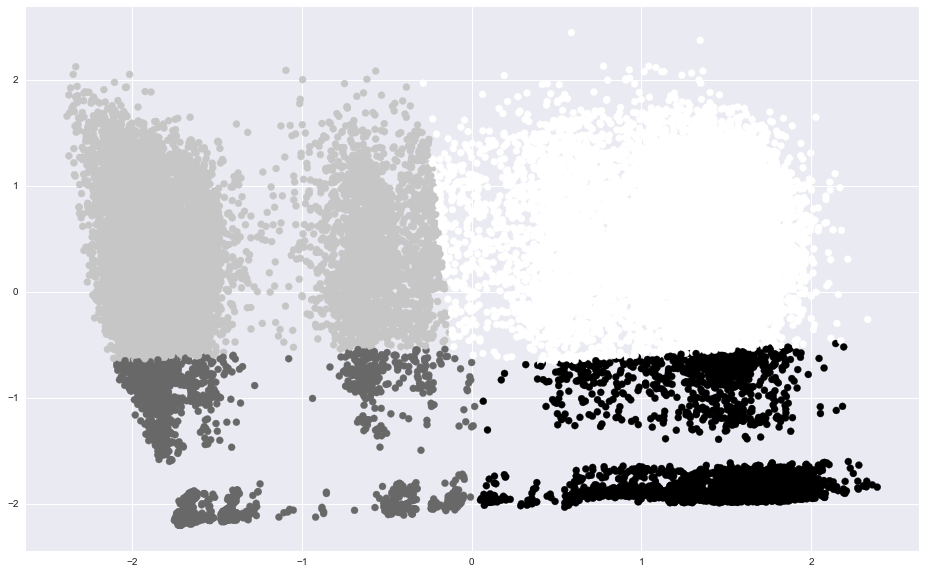

In [98]:
plt.pyplot.scatter(df_pca[:,0], df_pca[:,1], c=clustered_labels_km)


In [99]:
new_df['pca+kmeans'] = clustered_labels_km

In [100]:
X_train_km = df.loc[df.is_train]
X_test_km = df.loc[df.is_train == False]

In [103]:
X_train_km.tail()

,1,10,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,13,131,132,133,134,135,136,139,14,142,143,144,145,146,147,148,15,151,153,154,155,156,157,158,159,16,161,162,163,165,166,167,168,169,17,170,171,172,173,174,175,176,177,179,18,180,181,182,183,184,185,187,189,19,190,191,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,292,293,294,295,296,297,298,299,3,30,300,302,304,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target,is_train
30495,1,1,0.089138,0.310530,0.126254,0.888868,0.871319,0.196722,0.40,0.304348,0.444444,0.022528,0.5,0.503075,0.949102,0.615385,0.250856,0.916515,0.022528,0.5,0.503075,0.949102,1,0.096774,0.049495,0.834711,0.019834,0.5,0.442270,0.939371,0.021505,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.020696,0.786226,0.316665,0.370712,0.513644,0.461111,0,0,0.686579,0.270851,0.263962,1.000000,0.239716,0.722645,0.441629,0.065392,0.868829,0.303396,0,0.877532,1.000000,1.000000,0.528906,0.304619,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.031556,0.432451,0.347293,0.235026,0.590108,0,0.115465,1,0.886577,0,1.000000,0.000175,0.059220,0.431082,0.424557,0.778700,0.970290,0.848982,0.000000,1.000000,0,0.000000,0.000000,1,0.430418,0.858922,0.276931,0.109160,1,0,0,0,0,0.0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.00000,0.0,0.0,0.038462,0.003215,0.170736,1,1,1,0.151094,0.075385,0.0,True
30496,1,1,0.352568,0.089094,0.040110,0.823985,0.063204,0.217779,0.30,0.217391,0.500000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,0.000000,0.000000,0.000000,0.111766,0.5,0.180193,0.872006,0.032258,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.008744,0.738843,0.302739,0.308336,0.251577,0.486121,0,0,0.669765,0.728034,0.374239,0.691665,0.502599,0.509391,0.496008,0.407630,0.674485,0.347966,0,0.681187,1.000000,1.000000,1.000000,1.000000,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0.075937,0.572285,0.239612,1.000000,1.000000,0,0.108566,1,1.000000,0,0.449495,0.000550,0.132759,0.744490,1.000000,1.000000,1.000000,1.000000,0.017365,0.982634,0,0.060094,0.809281,1,1.000000,1.000000,1.000000,0.450414,1,0,0,0,0,0.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0,1,1,0.563204,0.322213,0.0,True
30497,1,1,1.000000,1.000000,0.057568,0.753314,0.250112,0.027848,0.20,0.173913,0.666667,0.143069,0.5,0.450169,0.910180,0.319089,0.079397,0.840290,0.308740,0.5,0.969052,0.997754,1,0.096774,0.021000,0.787328,0.089659,0.5,0.281079,0.904940,0.032258,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0

In [104]:
X_test_km.head()

,1,10,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,13,131,132,133,134,135,136,139,14,142,143,144,145,146,147,148,15,151,153,154,155,156,157,158,159,16,161,162,163,165,166,167,168,169,17,170,171,172,173,174,175,176,177,179,18,180,181,182,183,184,185,187,189,19,190,191,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,292,293,294,295,296,297,298,299,3,30,300,302,304,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target,is_train
0,1,1,0.389702,0.207745,0.046700,0.293568,0.133332,0.108743,0.30,0.304348,0.555556,0.052021,0.5,0.445127,0.844436,0.258310,0.120536,0.851549,0.308740,0.5,0.969052,0.997754,1,0.075269,0.044124,0.828099,0.014678,0.5,0.326132,0.916168,0.075269,0,0.555556,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.044124,0.828099,0.207479,0.152690,0.175073,0.549325,0,0,0.478620,0.509881,0.292150,0.702982,0.237822,0.645717,0.338190,0.249612,0.754017,0.304419,0,0.888042,1.0,1.0,0.761512,0.153585,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.388995,0.842112,0.461724,0.446615,0.078764,0,0.071850,1,0.279886,0,0.429293,0.051663,0.638350,0.499279,0.116236,0.001895,0.268333,0.623211,0.480870,0.519130,0,0.199035,0.890508,1,0.077291,0.574936,0.134728,0.192984,0,1,0,0,0,0.222222,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0.0,0.00000,0.0,0.0,0.136364,0.35921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.89803,0.0,0.17961,0.17961,0.153846,0.028939,0.457598,1,1,1,1.000000,1.000000,NaN,False
1,1,1,1.000000,0.390839,0.160103,0.753314,0.097754,0.198160,0.35,0.130435,0.555556,0.011364,0.5,0.237096,0.812458,0.531814,0.151517,0.872622,0.017888,0.5,0.374784,0.926647,1,0.096774,0.038142,0.820386,0.308740,0.5,0.969052,0.997754,0.021505,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.018921,0.781267,0.107577,0.186750,0.179621,0.420534,0,0,0.431057,0.942957,0.057501,0.672653,0.267041,0.515884,0.161280,0.092513,0.697888,0.206254,0,0.867580,1.0,1.0,0.768640,0.040349,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.075937,0.572285,0.239612,1.000000,1.000000,0,0.096645,1,0.087719,0,0.376263,0.011455,0.456479,0.113528,0.099443,0.007252,0.418232,0.596438,0.254130,0.741635,0,0.091947,0.838127,0,0.082511,0.585569,0.042731,0.195690,0,1,0,0,0,0.000000,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,0.00000,0.0,0.0,0.181818,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,1.0,0.00000,0.0,0.00000,0.00000,0.038462,0.014469,0.357848,0,1,1,0.135797,1.000000,NaN,False
2,1,1,0.003507,0.001145,0.000226,0.063283,0.081684,0.095361,0.30,0.130435,0.555556,0.025958,0.5,0.185889,0.800399,0.433048,0.096462,0.810446,0.037353,0.5,0.503075,0.949102,1,0.096774,0.049495,0.834711,0.000042,0.5,0.000042,0.249251,0.010753,0,0.000000,0,0,0,0,0,0,0,0,0,0,

In [105]:
lgb_train_km = lgb.Dataset(X_train_km.drop(['target', 'is_train'], axis=1), label=y, free_raw_data=False)

In [106]:
result_lgb_km = lgb.cv(parameters, lgb_train_km, n_rounds, folds=skf.split(X_train_km, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.676479 + 0.00702309
[2]	cv_agg's auc: 0.688973 + 0.00349094
[3]	cv_agg's auc: 0.698242 + 0.00465322
[4]	cv_agg's auc: 0.700176 + 0.00601274
[5]	cv_agg's auc: 0.703513 + 0.00737215
[6]	cv_agg's auc: 0.704807 + 0.00728201
[7]	cv_agg's auc: 0.70673 + 0.00770952
[8]	cv_agg's auc: 0.707146 + 0.00817458
[9]	cv_agg's auc: 0.707178 + 0.00839891
[10]	cv_agg's auc: 0.707532 + 0.00812406
[11]	cv_agg's auc: 0.708546 + 0.00757388
[12]	cv_agg's auc: 0.709323 + 0.00723347
[13]	cv_agg's auc: 0.710024 + 0.00619317
[14]	cv_agg's auc: 0.709928 + 0.0055426
[15]	cv_agg's auc: 0.709239 + 0.0057482
[16]	cv_agg's auc: 0.70879 + 0.00562107
[17]	cv_agg's auc: 0.709323 + 0.00556242
[18]	cv_agg's auc: 0.710329 + 0.00543624
[19]	cv_agg's auc: 0.710381 + 0.00539009
[20]	cv_agg's auc: 0.710671 + 0.00566522
[21]	cv_agg's auc: 0.710553 + 0.00576253
[22]	cv_agg's auc: 0.711401 + 0.00559863
[23]	cv_agg's auc: 0.711618 + 0.00532376
[24]	cv_agg's auc: 0.711773 + 0.00530651
[25]	cv_agg's auc: 0.712072 +

[200]	cv_agg's auc: 0.729902 + 0.00615075
[201]	cv_agg's auc: 0.730011 + 0.00618948
[202]	cv_agg's auc: 0.730046 + 0.00622497
[203]	cv_agg's auc: 0.730142 + 0.00616599
[204]	cv_agg's auc: 0.730144 + 0.00613309
[205]	cv_agg's auc: 0.730181 + 0.0061244
[206]	cv_agg's auc: 0.730295 + 0.00612378
[207]	cv_agg's auc: 0.730317 + 0.00608722
[208]	cv_agg's auc: 0.730429 + 0.00609067
[209]	cv_agg's auc: 0.730457 + 0.00610061
[210]	cv_agg's auc: 0.730522 + 0.00609493
[211]	cv_agg's auc: 0.730618 + 0.00610178
[212]	cv_agg's auc: 0.730687 + 0.00609308
[213]	cv_agg's auc: 0.730829 + 0.00606636
[214]	cv_agg's auc: 0.730943 + 0.00605284
[215]	cv_agg's auc: 0.731072 + 0.00601229
[216]	cv_agg's auc: 0.731157 + 0.00597409
[217]	cv_agg's auc: 0.731287 + 0.00598805
[218]	cv_agg's auc: 0.731393 + 0.00600295
[219]	cv_agg's auc: 0.731533 + 0.00607011
[220]	cv_agg's auc: 0.731589 + 0.00607013
[221]	cv_agg's auc: 0.731664 + 0.00610323
[222]	cv_agg's auc: 0.731655 + 0.00611672
[223]	cv_agg's auc: 0.731752 + 0.00

[401]	cv_agg's auc: 0.740419 + 0.0064883
[402]	cv_agg's auc: 0.740453 + 0.00644895
[403]	cv_agg's auc: 0.740453 + 0.00641911
[404]	cv_agg's auc: 0.740433 + 0.00639937
[405]	cv_agg's auc: 0.740445 + 0.00639543
[406]	cv_agg's auc: 0.740495 + 0.00640594
[407]	cv_agg's auc: 0.740572 + 0.00641625
[408]	cv_agg's auc: 0.740602 + 0.00638804
[409]	cv_agg's auc: 0.740631 + 0.00638711
[410]	cv_agg's auc: 0.740666 + 0.00635749
[411]	cv_agg's auc: 0.74071 + 0.00635277
[412]	cv_agg's auc: 0.740764 + 0.00635861
[413]	cv_agg's auc: 0.740755 + 0.00638151
[414]	cv_agg's auc: 0.740783 + 0.00635496
[415]	cv_agg's auc: 0.740797 + 0.00634162
[416]	cv_agg's auc: 0.74083 + 0.00635497
[417]	cv_agg's auc: 0.740865 + 0.00634026
[418]	cv_agg's auc: 0.740904 + 0.00636933
[419]	cv_agg's auc: 0.740901 + 0.00635397
[420]	cv_agg's auc: 0.740932 + 0.00634484
[421]	cv_agg's auc: 0.740922 + 0.00634773
[422]	cv_agg's auc: 0.74095 + 0.00636487
[423]	cv_agg's auc: 0.740966 + 0.00634722
[424]	cv_agg's auc: 0.740976 + 0.00631

[599]	cv_agg's auc: 0.74422 + 0.00624099
[600]	cv_agg's auc: 0.744246 + 0.00625286
[601]	cv_agg's auc: 0.744257 + 0.0062539
[602]	cv_agg's auc: 0.744279 + 0.00625658
[603]	cv_agg's auc: 0.744318 + 0.00627794
[604]	cv_agg's auc: 0.744337 + 0.00628732
[605]	cv_agg's auc: 0.744326 + 0.00627121
[606]	cv_agg's auc: 0.744335 + 0.00626731
[607]	cv_agg's auc: 0.744319 + 0.00628841
[608]	cv_agg's auc: 0.744321 + 0.00626566
[609]	cv_agg's auc: 0.744331 + 0.00625339
[610]	cv_agg's auc: 0.744341 + 0.00625337
[611]	cv_agg's auc: 0.74437 + 0.00626843
[612]	cv_agg's auc: 0.744397 + 0.00629564
[613]	cv_agg's auc: 0.744413 + 0.00629394
[614]	cv_agg's auc: 0.744412 + 0.00627862
[615]	cv_agg's auc: 0.744463 + 0.00625372
[616]	cv_agg's auc: 0.744484 + 0.00624806
[617]	cv_agg's auc: 0.744516 + 0.00629196
[618]	cv_agg's auc: 0.744519 + 0.00630715
[619]	cv_agg's auc: 0.74452 + 0.00631674
[620]	cv_agg's auc: 0.744512 + 0.00634407
[621]	cv_agg's auc: 0.744514 + 0.00632757
[622]	cv_agg's auc: 0.744499 + 0.00632

In [107]:
max(result_lgb_km['auc-mean']), len(result_lgb_km['auc-mean'])

(0.7458790586032003, 763)

In [109]:
#0.0004162012130765058

# dbscan and umap


In [110]:
X_test = test_df.drop(['0'], axis=1)

In [111]:
X_with_target = X.copy() 
X_with_target['target'] = y
new_df = pd.concat([X_with_target, X_test], axis=0)
# add column for filtering train/test
new_df['is_train'] = True
new_df.loc[df['target'].isnull(), 'is_train'] = False

In [112]:
ump = umap.UMAP(n_neighbors=22,
                 min_dist=0.01,
                 metric='correlation')

In [113]:
df_ump=ump.fit_transform(new_df[new_df.columns[:-2]])

eps - The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples - The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

In [116]:
dbscan = DBSCAN(
    eps=1,
    min_samples=30,
    n_jobs=n_jobs,
)

In [119]:
clustered_labels_dbscan = dbscan.fit_predict(df_ump)

In [120]:
np.unique(clustered_labels_dbscan).shape[0]

8

In [121]:
pd.Series(clustered_labels_dbscan).value_counts()

0    11394
1    10694
3     4794
2     3458
5     2038
6     1019
4      957
7      312
dtype: int64

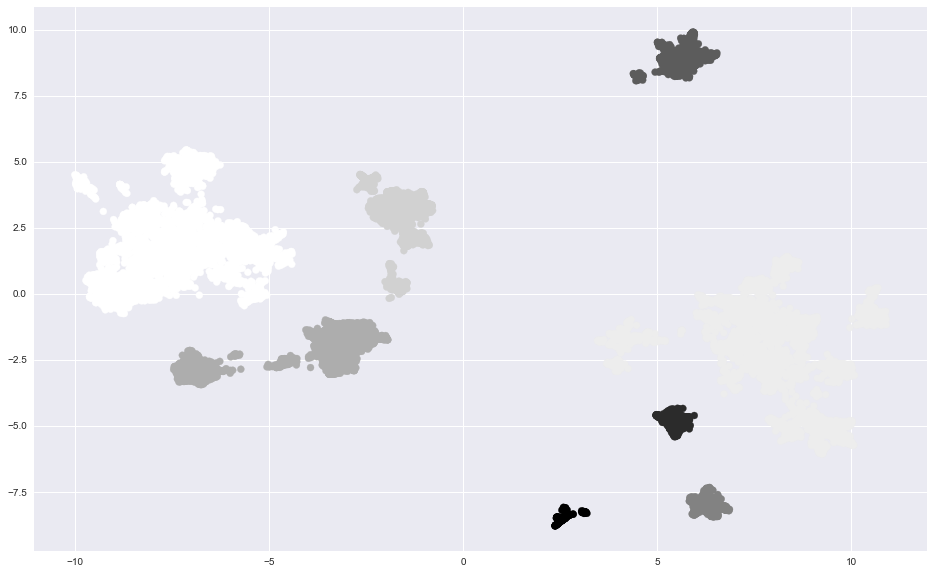

In [123]:
plt.pyplot.scatter(df_ump[:,0], df_ump[:,1], c=clustered_labels_dbscan)

In [124]:
new_df['dbscan+umap'] = clustered_labels_dbscan
X_train_dbscan = new_df.loc[new_df.is_train]
X_test_dbscan = new_df.loc[new_df.is_train == False]

In [127]:
new_df.head()

,1,10,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,12,120,121,122,123,124,125,126,127,128,13,131,132,133,134,135,136,139,14,142,143,144,145,146,147,148,15,151,153,154,155,156,157,158,159,16,161,162,163,165,166,167,168,169,17,170,171,172,173,174,175,176,177,179,18,180,181,182,183,184,185,187,189,19,190,191,194,195,196,197,198,199,2,20,200,201,202,203,204,205,206,207,208,209,21,210,211,212,213,214,215,216,217,218,219,22,220,221,222,223,224,225,226,227,228,229,23,230,231,232,233,234,235,236,237,238,239,24,240,241,242,243,244,245,246,247,248,249,25,250,251,252,253,254,255,256,257,258,259,26,260,261,262,263,264,265,266,267,268,269,27,270,271,272,273,274,275,276,277,278,279,28,280,281,282,283,284,285,286,287,288,289,29,290,292,293,294,295,296,297,298,299,3,30,300,302,304,306,307,308,309,31,310,311,312,313,314,315,316,317,318,319,32,320,321,322,323,324,325,326,327,328,329,33,330,331,332,333,334,335,336,337,338,339,34,340,341,342,343,344,345,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,6,60,61,62,63,64,65,66,67,68,69,7,70,71,72,73,74,75,76,77,78,79,8,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,target,is_train,dbscan+umap
0,1,1,0.352568,0.089094,0.011460,0.823985,0.063204,0.062223,0.35,0.173913,0.555556,0.075643,0.519230,0.293616,0.853005,0.315582,0.100401,0.837033,0.308740,0.75,0.969052,0.997754,1,0.064516,0.038252,0.820386,0.000000,0.50,0.000020,0.197605,0.021505,0,0.461538,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.028976,0.804959,0.256315,0.233609,0.207241,0.543609,0,0,0.636277,0.674055,0.411088,0.681005,0.492990,0.676865,0.510106,0.273482,0.666876,0.271396,0,0.743387,1.000000,1.0,0.761512,0.137851,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.130447,0.660812,0.150456,0.583333,0.341582,0,0.093772,1,0.332109,0,0.419192,0.062752,0.662008,0.181560,0.347370,0.004595,0.366032,0.813739,0.216998,0.783002,0,0.263109,0.909438,1,0.297790,0.797473,0.178935,0.221395,0,1,0,1,0,0.222222,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0.0,0.00000,0.0,0.0,0.090909,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.0000,0.00000,0.0,0.0,0,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.80904,0.00000,0.13484,0.40452,0.00000,0.40452,0.153846,0.020900,0.410139,1,1,1,0.936569,0.322213,1.0,True,0
1,1,1,0.352568,0.102546,0.036168,0.823985,0.072747,0.171335,0.25,0.217391,0.722222,0.103864,0.593750,0.073648,0.612603,0.222222,0.025549,0.737636,0.347640,1.00,0.341784,0.919910,1,0.064516,0.016164,0.773003,0.066100,0.50,0.067294,0.797904,0.053763,0,0.187500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.008943,0.740496,0.374360,0.171766,0.222209,0.707014,0,0,0.626137,0.644117,0.469494,0.668941,0.541728,0.716629,0.546316,0.482135,0.673065,0.381908,0,0.628642,1.000000,1.0,0.761512,0.107644,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.084065,0.588824,0.065451,0.488932,0.448880,0,0.093083,1,0.189719,0,0.310606,0.017096,0.504464,0.103531,0.256125,0.012358,0.480100,0.760360,0.280813,0.719187,0,0.252015,0.906516,0,0.207799,0.737641,0.110012,0.241508,0,1,0,0,0,0.111111,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0.0,0.00000,0.0,0.0,0.090909,0.0,0.46291,0.00000,0.15430,0.0,0.0,0.1543,0.00000,0.0,0.0,0,0.0,0.0,0.46291,0.46291,0.30861,0.0,0.46291,0.00000,0.00000,0.00000,0.00000,0.00000,0.269231,0.025723,0.440312,1,1,1,0.558273,0.322213,1.0,True,0
2,1,1,0.146644,0.000756,0.000024,1.000000,0.001289,0.015625,0.20,0.086957,0.611111,0.083598,0.575000,0.110840,0.690868,0.252991,0.041802,0.796249,0.395747,0.75,0.33

In [128]:
lgb_train_dbscan = lgb.Dataset(X_train_dbscan.drop(['target', 'is_train'], axis=1), label=y, free_raw_data=False)

In [129]:
result_lgb_dbscan = lgb.cv(parameters, lgb_train_dbscan, n_rounds, folds=skf.split(X_train_dbscan, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.676496 + 0.00728931
[2]	cv_agg's auc: 0.692056 + 0.00672483
[3]	cv_agg's auc: 0.696804 + 0.0079351
[4]	cv_agg's auc: 0.700596 + 0.00747102
[5]	cv_agg's auc: 0.701454 + 0.00773476
[6]	cv_agg's auc: 0.70526 + 0.00614734
[7]	cv_agg's auc: 0.705972 + 0.00623564
[8]	cv_agg's auc: 0.706519 + 0.00623958
[9]	cv_agg's auc: 0.706615 + 0.00606566
[10]	cv_agg's auc: 0.707509 + 0.00537888
[11]	cv_agg's auc: 0.70873 + 0.00545494
[12]	cv_agg's auc: 0.709802 + 0.00605946
[13]	cv_agg's auc: 0.709956 + 0.00604066
[14]	cv_agg's auc: 0.710442 + 0.00647737
[15]	cv_agg's auc: 0.71096 + 0.0066496
[16]	cv_agg's auc: 0.710628 + 0.00675757
[17]	cv_agg's auc: 0.710648 + 0.00624888
[18]	cv_agg's auc: 0.710991 + 0.00631708
[19]	cv_agg's auc: 0.711025 + 0.00632043
[20]	cv_agg's auc: 0.710986 + 0.00644351
[21]	cv_agg's auc: 0.711087 + 0.00640631
[22]	cv_agg's auc: 0.71119 + 0.006557
[23]	cv_agg's auc: 0.711735 + 0.00656751
[24]	cv_agg's auc: 0.712393 + 0.00612963
[25]	cv_agg's auc: 0.712437 + 0.0

[200]	cv_agg's auc: 0.730367 + 0.00580246
[201]	cv_agg's auc: 0.730445 + 0.00577557
[202]	cv_agg's auc: 0.730464 + 0.00579601
[203]	cv_agg's auc: 0.730534 + 0.00578506
[204]	cv_agg's auc: 0.730627 + 0.0057863
[205]	cv_agg's auc: 0.730695 + 0.0057627
[206]	cv_agg's auc: 0.730765 + 0.00577375
[207]	cv_agg's auc: 0.7308 + 0.00577602
[208]	cv_agg's auc: 0.730883 + 0.00572609
[209]	cv_agg's auc: 0.730921 + 0.00574825
[210]	cv_agg's auc: 0.730926 + 0.0057884
[211]	cv_agg's auc: 0.730986 + 0.0057655
[212]	cv_agg's auc: 0.731047 + 0.00570917
[213]	cv_agg's auc: 0.731139 + 0.00569349
[214]	cv_agg's auc: 0.731223 + 0.00564605
[215]	cv_agg's auc: 0.731296 + 0.00561489
[216]	cv_agg's auc: 0.731465 + 0.00568165
[217]	cv_agg's auc: 0.73158 + 0.00565509
[218]	cv_agg's auc: 0.731703 + 0.00566261
[219]	cv_agg's auc: 0.731842 + 0.00571124
[220]	cv_agg's auc: 0.731938 + 0.00571885
[221]	cv_agg's auc: 0.731959 + 0.00573657
[222]	cv_agg's auc: 0.732016 + 0.00577474
[223]	cv_agg's auc: 0.732102 + 0.00576369

[399]	cv_agg's auc: 0.740749 + 0.00629664
[400]	cv_agg's auc: 0.740763 + 0.00631732
[401]	cv_agg's auc: 0.740772 + 0.00632975
[402]	cv_agg's auc: 0.740805 + 0.00627142
[403]	cv_agg's auc: 0.740827 + 0.00626818
[404]	cv_agg's auc: 0.740859 + 0.00625648
[405]	cv_agg's auc: 0.740891 + 0.00627146
[406]	cv_agg's auc: 0.740928 + 0.00628214
[407]	cv_agg's auc: 0.740961 + 0.00630411
[408]	cv_agg's auc: 0.74097 + 0.00634906
[409]	cv_agg's auc: 0.740995 + 0.00634256
[410]	cv_agg's auc: 0.740976 + 0.00631728
[411]	cv_agg's auc: 0.741008 + 0.00632155
[412]	cv_agg's auc: 0.741055 + 0.00633512
[413]	cv_agg's auc: 0.741093 + 0.00631681
[414]	cv_agg's auc: 0.741118 + 0.00628336
[415]	cv_agg's auc: 0.741132 + 0.00627671
[416]	cv_agg's auc: 0.741173 + 0.00627614
[417]	cv_agg's auc: 0.74118 + 0.00629823
[418]	cv_agg's auc: 0.741215 + 0.00630207
[419]	cv_agg's auc: 0.741217 + 0.00630945
[420]	cv_agg's auc: 0.74123 + 0.0063472
[421]	cv_agg's auc: 0.741259 + 0.00635743
[422]	cv_agg's auc: 0.741284 + 0.00633

[598]	cv_agg's auc: 0.744412 + 0.00643683
[599]	cv_agg's auc: 0.744432 + 0.00642931
[600]	cv_agg's auc: 0.744421 + 0.00645987
[601]	cv_agg's auc: 0.744428 + 0.00646794
[602]	cv_agg's auc: 0.744463 + 0.00648274
[603]	cv_agg's auc: 0.744491 + 0.00648846
[604]	cv_agg's auc: 0.744508 + 0.00651565
[605]	cv_agg's auc: 0.744521 + 0.00656148
[606]	cv_agg's auc: 0.744553 + 0.00656195
[607]	cv_agg's auc: 0.744551 + 0.00659164
[608]	cv_agg's auc: 0.744594 + 0.00661859
[609]	cv_agg's auc: 0.744579 + 0.00660956
[610]	cv_agg's auc: 0.744574 + 0.00661106
[611]	cv_agg's auc: 0.744581 + 0.00661344
[612]	cv_agg's auc: 0.744609 + 0.00663334
[613]	cv_agg's auc: 0.74463 + 0.00660929
[614]	cv_agg's auc: 0.744635 + 0.00656859
[615]	cv_agg's auc: 0.744649 + 0.00656571
[616]	cv_agg's auc: 0.744661 + 0.00655774
[617]	cv_agg's auc: 0.744641 + 0.00657451
[618]	cv_agg's auc: 0.744644 + 0.00657676
[619]	cv_agg's auc: 0.744667 + 0.00656881
[620]	cv_agg's auc: 0.744663 + 0.0065947
[621]	cv_agg's auc: 0.744652 + 0.006

In [233]:
max(result_lgb_dbscan['auc-mean']), len(result_lgb_dbscan['auc-mean'])

(0.7450444878057256, 668)

# Feature Selection

In [133]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_classif

## k best

In [281]:
kb = SelectKBest(f_classif, k=315).fit(X, y)

In [282]:
X_test.shape

(4166, 322)

In [283]:
X_train_kb = kb.transform(X)
X_test_kb = kb.transform(X_test)

In [285]:
lgb_train_kb = lgb.Dataset(X_train_kb, label=y, free_raw_data=False) 

In [286]:
result_lgb_kb = lgb.cv(parameters, lgb_train_kb, n_rounds, folds=skf.split(X_train_kb, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.682144 + 0.00718003
[2]	cv_agg's auc: 0.689088 + 0.00960935
[3]	cv_agg's auc: 0.695786 + 0.00893923
[4]	cv_agg's auc: 0.700122 + 0.00958175
[5]	cv_agg's auc: 0.701713 + 0.00940188
[6]	cv_agg's auc: 0.704246 + 0.00935908
[7]	cv_agg's auc: 0.70507 + 0.00910492
[8]	cv_agg's auc: 0.70681 + 0.00832897
[9]	cv_agg's auc: 0.708075 + 0.00840602
[10]	cv_agg's auc: 0.709341 + 0.00851318
[11]	cv_agg's auc: 0.709724 + 0.00808105
[12]	cv_agg's auc: 0.709837 + 0.00816912
[13]	cv_agg's auc: 0.710672 + 0.00798699
[14]	cv_agg's auc: 0.711418 + 0.00778612
[15]	cv_agg's auc: 0.711423 + 0.00788476
[16]	cv_agg's auc: 0.711319 + 0.00819259
[17]	cv_agg's auc: 0.711483 + 0.0083273
[18]	cv_agg's auc: 0.711699 + 0.00794977
[19]	cv_agg's auc: 0.711492 + 0.00785707
[20]	cv_agg's auc: 0.711352 + 0.00771109
[21]	cv_agg's auc: 0.711413 + 0.00773268
[22]	cv_agg's auc: 0.711679 + 0.0077267
[23]	cv_agg's auc: 0.711839 + 0.00761309
[24]	cv_agg's auc: 0.712024 + 0.00733588
[25]	cv_agg's auc: 0.7123 + 0

[200]	cv_agg's auc: 0.729879 + 0.00685809
[201]	cv_agg's auc: 0.729977 + 0.00682079
[202]	cv_agg's auc: 0.73001 + 0.00679491
[203]	cv_agg's auc: 0.730087 + 0.00680013
[204]	cv_agg's auc: 0.730215 + 0.00679746
[205]	cv_agg's auc: 0.730257 + 0.00677945
[206]	cv_agg's auc: 0.730364 + 0.00678817
[207]	cv_agg's auc: 0.73042 + 0.00675893
[208]	cv_agg's auc: 0.73048 + 0.00674591
[209]	cv_agg's auc: 0.73051 + 0.0067269
[210]	cv_agg's auc: 0.730576 + 0.00670412
[211]	cv_agg's auc: 0.730601 + 0.00666651
[212]	cv_agg's auc: 0.730721 + 0.00667042
[213]	cv_agg's auc: 0.730825 + 0.00661104
[214]	cv_agg's auc: 0.730941 + 0.00659738
[215]	cv_agg's auc: 0.731069 + 0.00663403
[216]	cv_agg's auc: 0.731164 + 0.00666405
[217]	cv_agg's auc: 0.731334 + 0.00664473
[218]	cv_agg's auc: 0.731438 + 0.00663705
[219]	cv_agg's auc: 0.73157 + 0.00665091
[220]	cv_agg's auc: 0.731586 + 0.00661544
[221]	cv_agg's auc: 0.731649 + 0.00664221
[222]	cv_agg's auc: 0.731692 + 0.00659827
[223]	cv_agg's auc: 0.731764 + 0.0066166

[399]	cv_agg's auc: 0.739998 + 0.00668795
[400]	cv_agg's auc: 0.739998 + 0.006703
[401]	cv_agg's auc: 0.740039 + 0.00667327
[402]	cv_agg's auc: 0.740077 + 0.00666234
[403]	cv_agg's auc: 0.740082 + 0.00669424
[404]	cv_agg's auc: 0.740105 + 0.00666289
[405]	cv_agg's auc: 0.740117 + 0.00664385
[406]	cv_agg's auc: 0.74017 + 0.00661825
[407]	cv_agg's auc: 0.740232 + 0.00662166
[408]	cv_agg's auc: 0.740228 + 0.00661081
[409]	cv_agg's auc: 0.740265 + 0.00655875
[410]	cv_agg's auc: 0.740295 + 0.00650866
[411]	cv_agg's auc: 0.740323 + 0.0065309
[412]	cv_agg's auc: 0.740364 + 0.00655869
[413]	cv_agg's auc: 0.740385 + 0.00652591
[414]	cv_agg's auc: 0.740412 + 0.00652848
[415]	cv_agg's auc: 0.740425 + 0.00651514
[416]	cv_agg's auc: 0.74046 + 0.00649097
[417]	cv_agg's auc: 0.74048 + 0.00650902
[418]	cv_agg's auc: 0.7405 + 0.00652049
[419]	cv_agg's auc: 0.740515 + 0.00652722
[420]	cv_agg's auc: 0.740521 + 0.0065768
[421]	cv_agg's auc: 0.740588 + 0.00656787
[422]	cv_agg's auc: 0.740575 + 0.00654376
[

[598]	cv_agg's auc: 0.744007 + 0.00627956
[599]	cv_agg's auc: 0.744022 + 0.00627235
[600]	cv_agg's auc: 0.744045 + 0.00628677
[601]	cv_agg's auc: 0.744065 + 0.00627351
[602]	cv_agg's auc: 0.744068 + 0.00628503
[603]	cv_agg's auc: 0.744069 + 0.00627374
[604]	cv_agg's auc: 0.744071 + 0.00626464
[605]	cv_agg's auc: 0.744062 + 0.00627087
[606]	cv_agg's auc: 0.744051 + 0.00624128
[607]	cv_agg's auc: 0.744062 + 0.00624943
[608]	cv_agg's auc: 0.744078 + 0.00626212
[609]	cv_agg's auc: 0.744118 + 0.00624847
[610]	cv_agg's auc: 0.744121 + 0.00624443
[611]	cv_agg's auc: 0.744133 + 0.00626842
[612]	cv_agg's auc: 0.744144 + 0.00628322
[613]	cv_agg's auc: 0.744105 + 0.00628839
[614]	cv_agg's auc: 0.744088 + 0.00626823
[615]	cv_agg's auc: 0.744112 + 0.00628719
[616]	cv_agg's auc: 0.744129 + 0.00629324
[617]	cv_agg's auc: 0.744147 + 0.00631738
[618]	cv_agg's auc: 0.744145 + 0.00633052
[619]	cv_agg's auc: 0.744138 + 0.00635404
[620]	cv_agg's auc: 0.744144 + 0.00632907
[621]	cv_agg's auc: 0.744148 + 0.0

In [287]:
max(result_lgb_kb['auc-mean']), len(result_lgb_kb['auc-mean']) #(0.7453376214709089, 731)

(0.7453376214709089, 731)

In [239]:
#parameters['n_rounds'] = 731

In [288]:
n_rounds = 731

In [295]:
X_train, X_val, y_train, y_val = train_test_split(X_train_kb, y, test_size=0.12, random_state=42)

In [296]:
train_data = lgb.Dataset(X_train, y_train)

In [297]:
bst = lgb.train(parameters, train_data, n_rounds)

In [298]:
val_pred = bst.predict(X_val,num_iteration=bst.best_iteration)

In [299]:
val_pred

array([0.19395254, 0.11053324, 0.09579727, ..., 0.0641481 , 0.11971753,
       0.46735311])

In [303]:
roc_auc_score(y_val,val_pred)

0.7500913660526343

In [310]:
bst = lgb.train(parameters, lgb_train_kb,n_rounds)

In [314]:
predict_lgb = bst.predict(X_test_kb,num_iteration=bst.best_iteration)

In [315]:
test_index = pd.read_csv('test.csv', sep='\t')
test_index = test_index['Unnamed: 0']

In [316]:
submition = pd.DataFrame({'_ID_': test_index, '_VAL_': np.zeros_like(test_index)})
submition['_VAL_'] = predict_lgb
submition.to_csv('submission_lgb.csv', index=False)

# CV 0.7453376214709089
# LB 0.75959437

## Select from model

In [169]:
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [170]:
pipe = make_pipeline(
    SelectFromModel(estimator=RandomForestClassifier()),
    LogisticRegression()
)

In [171]:
lr = LogisticRegression()
rf = RandomForestClassifier()

In [174]:
print(
    cross_val_score(lr, X, y, 
                    scoring='neg_log_loss', cv=skf).mean()
)
print(
    cross_val_score(rf, X, y, 
                    scoring='neg_log_loss', cv=skf).mean()
)
print(
    cross_val_score(pipe, X, y, 
                    scoring='neg_log_loss', cv=skf).mean()
)

-0.41765850150747463
-1.1214610763380495
-0.4307130172633504


In [164]:
bst = lgb.train(parameters, lgb_train_km, n_rounds)

In [175]:
sfm = SelectFromModel(rf).fit(X, y)

In [176]:
X_train_sfm = sfm.transform(X)
X_test_sfm = sfm.transform(X_test)

In [178]:
lgb_train_sfm = lgb.Dataset(X_train_sfm, label=y, free_raw_data=False)

In [180]:
result_lgb_sfm = lgb.cv(parameters, lgb_train_sfm, n_rounds, folds=skf.split(X_train_sfm, y), early_stopping_rounds=10, verbose_eval=1, )

[1]	cv_agg's auc: 0.665442 + 0.00537444
[2]	cv_agg's auc: 0.675938 + 0.00673947
[3]	cv_agg's auc: 0.686033 + 0.00863485
[4]	cv_agg's auc: 0.69609 + 0.00678928
[5]	cv_agg's auc: 0.696147 + 0.00782225
[6]	cv_agg's auc: 0.697806 + 0.00697946
[7]	cv_agg's auc: 0.69908 + 0.00600511
[8]	cv_agg's auc: 0.700613 + 0.00537866
[9]	cv_agg's auc: 0.702515 + 0.00587758
[10]	cv_agg's auc: 0.702333 + 0.00660762
[11]	cv_agg's auc: 0.702387 + 0.00696314
[12]	cv_agg's auc: 0.703255 + 0.00652983
[13]	cv_agg's auc: 0.703232 + 0.00671323
[14]	cv_agg's auc: 0.703313 + 0.00646532
[15]	cv_agg's auc: 0.703591 + 0.00687419
[16]	cv_agg's auc: 0.703461 + 0.00653837
[17]	cv_agg's auc: 0.703069 + 0.00681909
[18]	cv_agg's auc: 0.703119 + 0.00672915
[19]	cv_agg's auc: 0.703663 + 0.00681074
[20]	cv_agg's auc: 0.704006 + 0.00710642
[21]	cv_agg's auc: 0.704368 + 0.00689471
[22]	cv_agg's auc: 0.704747 + 0.00712498
[23]	cv_agg's auc: 0.705258 + 0.00697706
[24]	cv_agg's auc: 0.705463 + 0.00702015
[25]	cv_agg's auc: 0.705947

[200]	cv_agg's auc: 0.723344 + 0.00622011
[201]	cv_agg's auc: 0.723384 + 0.00622604
[202]	cv_agg's auc: 0.723458 + 0.00626811
[203]	cv_agg's auc: 0.723467 + 0.00620782
[204]	cv_agg's auc: 0.723569 + 0.00617666
[205]	cv_agg's auc: 0.723611 + 0.00620578
[206]	cv_agg's auc: 0.723687 + 0.00623807
[207]	cv_agg's auc: 0.723773 + 0.00623869
[208]	cv_agg's auc: 0.723891 + 0.0063564
[209]	cv_agg's auc: 0.723939 + 0.00635644
[210]	cv_agg's auc: 0.723969 + 0.00631349
[211]	cv_agg's auc: 0.724021 + 0.00637186
[212]	cv_agg's auc: 0.724041 + 0.00639747
[213]	cv_agg's auc: 0.724193 + 0.00642974
[214]	cv_agg's auc: 0.724272 + 0.00643416
[215]	cv_agg's auc: 0.724364 + 0.0064127
[216]	cv_agg's auc: 0.724428 + 0.00638373
[217]	cv_agg's auc: 0.724526 + 0.00638432
[218]	cv_agg's auc: 0.724637 + 0.00635365
[219]	cv_agg's auc: 0.724672 + 0.00635766
[220]	cv_agg's auc: 0.724739 + 0.00632952
[221]	cv_agg's auc: 0.724713 + 0.00633509
[222]	cv_agg's auc: 0.724796 + 0.00630396
[223]	cv_agg's auc: 0.724961 + 0.006

[396]	cv_agg's auc: 0.733569 + 0.00597519
[397]	cv_agg's auc: 0.733583 + 0.00597169
[398]	cv_agg's auc: 0.733591 + 0.00592556
[399]	cv_agg's auc: 0.733622 + 0.00589916
[400]	cv_agg's auc: 0.733603 + 0.00593571
[401]	cv_agg's auc: 0.733646 + 0.00590775
[402]	cv_agg's auc: 0.733683 + 0.00591559
[403]	cv_agg's auc: 0.733687 + 0.00587766
[404]	cv_agg's auc: 0.733725 + 0.00589143
[405]	cv_agg's auc: 0.733756 + 0.0058888
[406]	cv_agg's auc: 0.733788 + 0.0058656
[407]	cv_agg's auc: 0.733831 + 0.00588234
[408]	cv_agg's auc: 0.73389 + 0.00583996
[409]	cv_agg's auc: 0.733953 + 0.00581338
[410]	cv_agg's auc: 0.734001 + 0.00579201
[411]	cv_agg's auc: 0.734034 + 0.00579375
[412]	cv_agg's auc: 0.734055 + 0.00581213
[413]	cv_agg's auc: 0.734095 + 0.00582305
[414]	cv_agg's auc: 0.734122 + 0.00581476
[415]	cv_agg's auc: 0.734161 + 0.0057951
[416]	cv_agg's auc: 0.734158 + 0.00577918
[417]	cv_agg's auc: 0.734195 + 0.00575832
[418]	cv_agg's auc: 0.734221 + 0.00577735
[419]	cv_agg's auc: 0.73425 + 0.005762

[598]	cv_agg's auc: 0.738285 + 0.00621352
[599]	cv_agg's auc: 0.738293 + 0.00626004
[600]	cv_agg's auc: 0.738313 + 0.00626796
[601]	cv_agg's auc: 0.73835 + 0.0062992
[602]	cv_agg's auc: 0.738381 + 0.00633322
[603]	cv_agg's auc: 0.738388 + 0.006291
[604]	cv_agg's auc: 0.738406 + 0.00627796
[605]	cv_agg's auc: 0.738435 + 0.00632452
[606]	cv_agg's auc: 0.73848 + 0.00630238
[607]	cv_agg's auc: 0.738456 + 0.00631002
[608]	cv_agg's auc: 0.738475 + 0.00630763
[609]	cv_agg's auc: 0.73848 + 0.00632484
[610]	cv_agg's auc: 0.738483 + 0.00632787
[611]	cv_agg's auc: 0.738527 + 0.00632012
[612]	cv_agg's auc: 0.738536 + 0.00631407
[613]	cv_agg's auc: 0.738561 + 0.00633569
[614]	cv_agg's auc: 0.738588 + 0.00630693
[615]	cv_agg's auc: 0.738629 + 0.0063292
[616]	cv_agg's auc: 0.738631 + 0.00637231
[617]	cv_agg's auc: 0.738621 + 0.00635113
[618]	cv_agg's auc: 0.738639 + 0.00633792
[619]	cv_agg's auc: 0.738636 + 0.0063229
[620]	cv_agg's auc: 0.738635 + 0.00632815
[621]	cv_agg's auc: 0.738624 + 0.00632423


In [181]:
max(result_lgb_sfm['auc-mean']), len(result_lgb_sfm['auc-mean'])

(0.7386391302991255, 618)